In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from google.colab import drive
from torch.cuda.amp import GradScaler, autocast

In [ ]:
# Check device (GPU/CPU)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("current device: ", device)

current device:  cuda


In [ ]:
drive.mount("/content/drive")
%cd /content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py/

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/cifar-10-batches-py


In [ ]:
# Parameters (my choice, can be changed)
args = {
    'lr': 1e-4,
    'batch_size': 128,
    'num_epochs': 20,
    'data_path': '/content/drive/MyDrive/Colab Notebooks/Vision_Transformer',
    'net': 'vit',
    'patch_size': 16,
    'dim': 256,
    'depth': 6,
    'heads': 8,
    'mlp_dim': 512
}

In [ ]:
# Data preparation
transform = transforms.Compose([
    transforms.Resize(256),  # Resize to the input size expected by ViT
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
trainset = torchvision.datasets.CIFAR10(root=args['data_path'], train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=args['batch_size'], shuffle=True)

testset = torchvision.datasets.CIFAR10(root=args['data_path'], train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args['batch_size'], shuffle=False)

100%|██████████| 170498071/170498071 [00:13<00:00, 13058563.65it/s]


Extracting /content/drive/MyDrive/Colab Notebooks/Vision_Transformer/cifar-10-python.tar.gz to /content/drive/MyDrive/Colab Notebooks/Vision_Transformer
Files already downloaded and verified


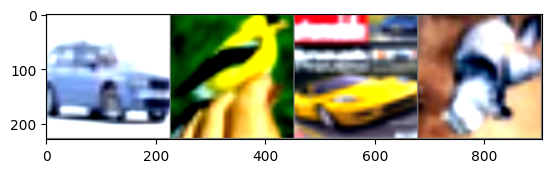

In [ ]:
# Visualize some sample images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))

In [ ]:
# Import Vision Transformer from timm library
# !pip install timm
import timm
model = timm.create_model('vit_small_patch16_224', pretrained=False, num_classes=10)

# Modify the model to fit CIFAR-10
model.head = nn.Linear(model.head.in_features, 10)
model = model.to(device)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args['lr'])

In [ ]:
# Training function
def train(model, trainloader, optimizer, criterion, device):
    model.train()
    scaler = GradScaler()
    epoch_loss = 0.0
    total_batches = len(trainloader)

    for inputs, targets in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, targets)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / total_batches
    print(f'Training loss for this epoch: {avg_loss:.4f}')
    return avg_loss

# Testing function
def test(model, testloader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    avg_loss = test_loss / len(testloader)
    accuracy = correct / total * 100
    print(f'Validation loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')
    return avg_loss, accuracy

In [ ]:
num_batches_per_epoch = len(trainloader)
print(f'Number of batches per epoch: {num_batches_per_epoch}')

Number of batches per epoch: 391


In [ ]:
# Training and testing
losstr = []
lossva = []
acc = []
for epoch in range(1, args['num_epochs'] + 1):
    print(f'Epoch {epoch}/{args["num_epochs"]}')
    train_loss = train(model, trainloader, optimizer, criterion, device)
    test_loss, test_accuracy = test(model, testloader, criterion, device)
    print(f'Training Loss: {train_loss:.4f}, Validation Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%\n')
    losstr.append(train_loss)
    lossva.append(test_loss)
    acc.append(test_accuracy)

Epoch 1/20
Training loss for this epoch: 1.1992
Validation loss: 1.1779, Accuracy: 57.07%
Training Loss: 1.1992, Validation Loss: 1.1779, Accuracy: 57.07%

Epoch 2/20
Training loss for this epoch: 1.1040
Validation loss: 1.1083, Accuracy: 60.95%
Training Loss: 1.1040, Validation Loss: 1.1083, Accuracy: 60.95%

Epoch 3/20
Training loss for this epoch: 1.0066
Validation loss: 1.0779, Accuracy: 62.08%
Training Loss: 1.0066, Validation Loss: 1.0779, Accuracy: 62.08%

Epoch 4/20
Training loss for this epoch: 0.9345
Validation loss: 0.9574, Accuracy: 66.48%
Training Loss: 0.9345, Validation Loss: 0.9574, Accuracy: 66.48%

Epoch 5/20
Training loss for this epoch: 0.8548
Validation loss: 0.9676, Accuracy: 65.50%
Training Loss: 0.8548, Validation Loss: 0.9676, Accuracy: 65.50%

Epoch 6/20
Training loss for this epoch: 0.7907
Validation loss: 0.8960, Accuracy: 68.12%
Training Loss: 0.7907, Validation Loss: 0.8960, Accuracy: 68.12%

Epoch 7/20
Training loss for this epoch: 0.7317
Validation loss:

Plot the Result:

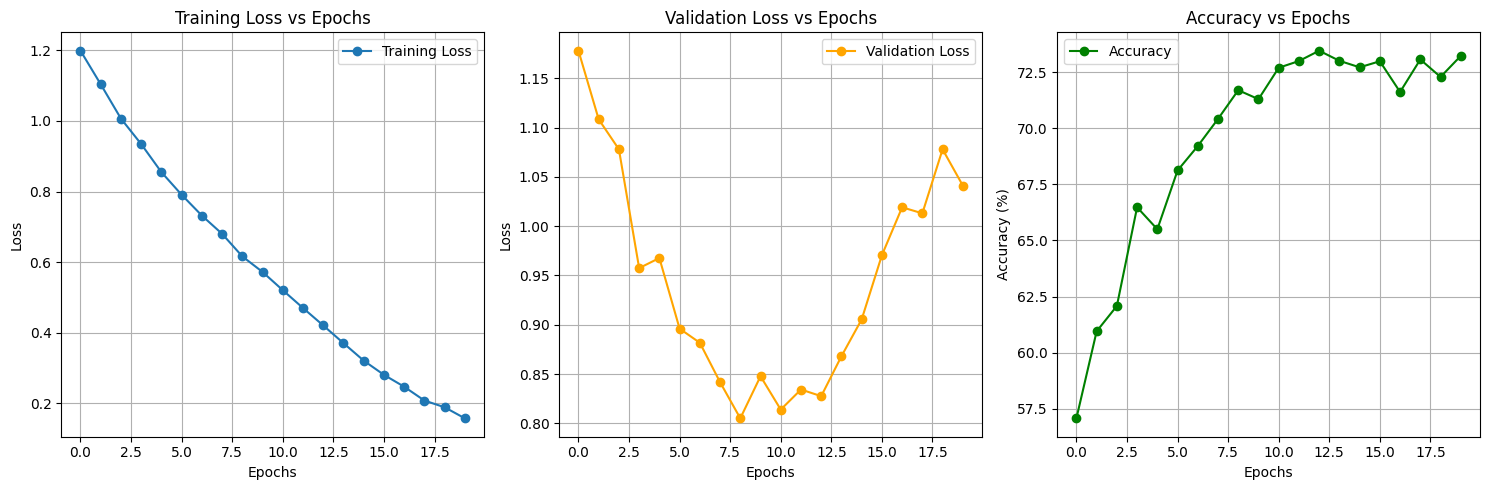

In [ ]:
# Plotting training loss
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(losstr, label='Training Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss vs Epochs')
plt.grid(True)
plt.legend()

# Plotting validation loss
plt.subplot(1, 3, 2)
plt.plot(lossva, label='Validation Loss', marker='o', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss vs Epochs')
plt.grid(True)
plt.legend()

# Plotting accuracy
plt.subplot(1, 3, 3)
plt.plot(acc, label='Accuracy', marker='o', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
